In [1]:
#%cd drive/My\ Drive/U\ of\ C/STAT\ 543/STAT_543_project

In [2]:
!pip install -U scikit-learn==0.24
!pip install -U imbalanced-learn

     |████████████████████████████████| 22.3 MB 9.1 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.0 which is incompatible.


## Importing packages

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline

# Imbalanced Learn module
import imblearn

# Scaler
from sklearn.preprocessing import StandardScaler

#Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

## Data Cleaning

In [4]:
polish_3_year = pd.read_csv("../input/stat543/3year.csv")
polish_attr = pd.read_csv("../input/stat543/attr_name.csv")
polish_3_year.replace({"?": np.nan }, inplace= True)
for col in polish_3_year.columns[:-1]:
    polish_3_year[col] = polish_3_year[col].astype("float64")
attr_map = {}
for row in polish_attr.itertuples(index = False):
    attr_map[row[0]] = row[1]
polish_3_year.rename(columns = attr_map, inplace = True)
polish_3_year.drop(columns=["id"], inplace=True)
polish_3_year.shape

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (15,24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(10503, 65)

### Removing Missing Values

In [5]:
more_than_500_NA = polish_3_year.isna().sum()[polish_3_year.isna().sum() > 500]
more_than_500_NA

sales (n) / sales (n-1)                                    807
profit on operating activities / financial expenses        715
(current assets - inventories) / long-term liabilities    4736
net profit / inventory                                     591
sales / inventory                                          592
dtype: int64

In [6]:
data = polish_3_year.drop(columns = more_than_500_NA.index ).dropna()

X = data.drop(columns=["class"])
y = data["class"]

print("Before Dropping NA:")
print(polish_3_year.groupby('class').size())
print("\nAfter Dropping NA:")
print(data.groupby('class').size() )

Before Dropping NA:
class
0    10008
1      495
dtype: int64

After Dropping NA:
class
0    9277
1     475
dtype: int64


### Detecting Potential Outliers

In [7]:
non_ratios = ['[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365',
              '(total liabilities * 365) / (gross profit + depreciation)', 
              '(inventory * 365) / sales', 
              '(current liabilities * 365) / cost of products sold', 
              'rotation receivables + inventory turnover in days',
              '(receivables * 365) / sales', 
              '(inventory * 365) / cost of products sold', 
              'working capital', 
              '(short-term liabilities *365) / sales']
X.describe()

,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,...,constant capital / fixed assets,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs /total sales,long-term liabilities / equity,sales / receivables,(short-term liabilities *365) / sales,sales / short-term liabilities,sales / fixed assets
count,9752.000000,9752.000000,9752.000000,9752.000000,9.752000e+03,9752.000000,9752.000000,9752.000000,9752.000000,9752.000000,...,9752.000000,9.752000e+03,9752.000000,9752.000000,9752.000000,9752.000000,9752.000000,9.752000e+03,9752.000000,9752.000000
mean,0.051600,0.515888,0.181486,3.865705,-1.432025e+03,0.001926,0.064508,10.914967,1.764718,0.467592,...,6.476850,6.833500e+03,-0.583899,-0.052977,1.621006,1.537521,13.762093,-1.784091e+01,8.605283,35.621111
std,0.246216,0.453837,0.404276,36.058037,1.228921e+05,0.926228,0.255076,434.357741,7.626330,0.470739,...,94.997248,6.086011e+04,57.974726,19.333040,57.926556,80.170766,82.483066,2.434534e+04,26.819405,438.000507
min,-6.453500,0.000034,-10.579000,0.006468,-1.190300e+07,-70.966000,-6.453500,-2.081800,-0.000084,-15.643000,...,-706.490000,-7.513800e+05,-5691.700000,-1667.300000,-1.328100,-142.790000,-0.014534,-2.336500e+06,-0.000156,-0.000102
25%,0.001280,0.258823,0.014270,1.034175,-5.224150e+01,0.000000,0.003055,0.438290,1.011875,0.299820,...,0.944410,1.112050e+01,0.004847,0.007484,0.884160,0.000000,4.548625,4.150275e+01,3.088025,2.021000
50%,0.043440,0.465455,0.189010,1.576650,3.333850e-01,0.000000,0.051630,1.106450,1.180500,0.513100,...,1.358750,9.722100e+02,0.049528,0.106970,0.955075,0.007428,6.741500,7.106050e+01,5.134900,4.012650
75%,0.122340,0.685893,0.401342,2.859375,5.325850e+01,0.086426,0.141250,2.778875,2.012200,0.719600,...,2.366775,4.617400e+03,0.122438,0.268122,0.996193,0.260740,10.659000,1.181800e+02,8.793850,9.470150
max,10.503000,16.643000,0.993960,3171.700000,6.854400e+05,25.413000,10.503000,29636.000000,740.440000,11.837000,...,6234.300000,3.380500e+06,293.150000,552.640000,5693.700000,7617.300000,4470.400000,5.018400e+05,1974.500000,21499.000000


In [8]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Detecting Using z score
z = np.abs(stats.zscore(X))

z_thres = 6

X_z_no = X[(z < z_thres).all(axis=1)]
y_z_no = y[(z < z_thres).all(axis=1)]

X_z_o = X[(z >= z_thres).any(axis=1)]
y_z_o = y[(z >= z_thres).any(axis=1)]


# Detecting using Random Forest
isof = IsolationForest(random_state = 0)
isof.fit(X)
X_outlier_pred = isof.predict(X)

X_iso_no = X[X_outlier_pred == 1]
y_iso_no = y[X_outlier_pred == 1]

X_iso_o = X[X_outlier_pred == -1]
y_iso_o = y[X_outlier_pred == -1]

print(f"Classes in Original Sample: {Counter(y)} \n")

print("  Using Z-score:")
print(f'Classes after removing Potential Outliers: { Counter(y_z_no) }')
print(f'Classes among Potential Outliers: { Counter(y_z_o) }')

print("\n   Using Isolation Forest:")
print(f'Classes after removing Potential Outliers: { Counter(y_iso_no) }')
print(f'Classes among Potential Outliers: { Counter(y_iso_o) }')

Classes in Original Sample: Counter({0: 9277, 1: 475}) 

  Using Z-score:
Classes after removing Potential Outliers: Counter({0: 9022, 1: 458})
Classes among Potential Outliers: Counter({0: 255, 1: 17})

   Using Isolation Forest:
Classes after removing Potential Outliers: Counter({0: 9027, 1: 447})
Classes among Potential Outliers: Counter({0: 250, 1: 28})


In [9]:
# Overlap between two methods
len(X_iso_o.join(X_z_o, how = "inner", rsuffix =  "_z"))

118

## Multicollinearity

In [10]:
# Method: Variable Inflation Factor
# Reference: https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif.sort_values(by = "VIF", ascending=False, inplace=True)
    return vif

In [11]:
calc_vif(X_z_no).head()

/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
6,EBIT / total assets,inf
17,gross profit / total assets,inf
13,(gross profit + interest) / total assets,inf
39,rotation receivables + inventory turnover in days,9.471830e+09
40,(receivables * 365) / sales,7.443413e+09


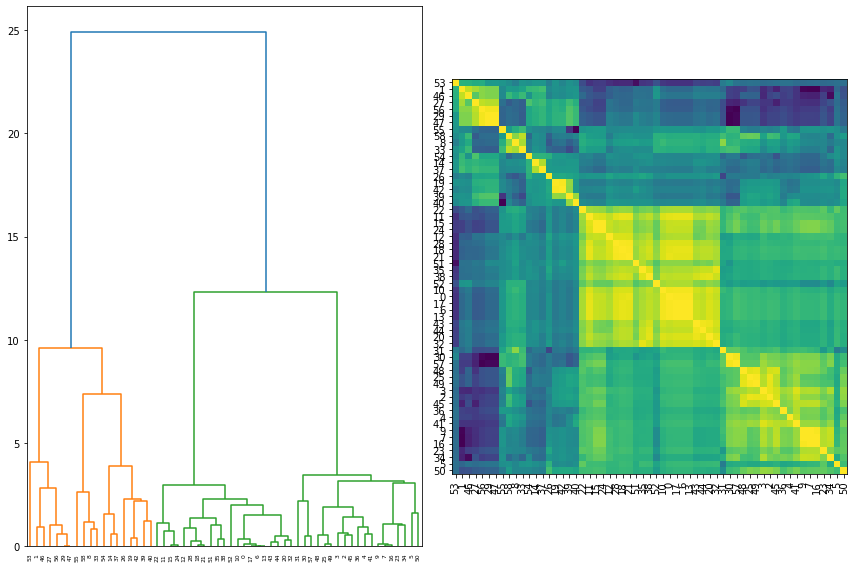

In [12]:
# Method: Hierarchical clustering on the Spearman rank-order correlations
# Reference: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

from collections import defaultdict
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Calculate Correlation based on Spearman's Rank

def plot_spearman_cor(X):
    corr = spearmanr(X).correlation
    corr_linkage = hierarchy.ward(corr)
    dendro = hierarchy.dendrogram(
        corr_linkage, labels=  np.arange(len(X.columns)) , ax=ax1, leaf_rotation=90
    )
    dendro_idx = np.arange(0, len(dendro['ivl']))

    ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
    ax2.set_xticks(dendro_idx)
    ax2.set_yticks(dendro_idx)
    ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
    ax2.set_yticklabels(dendro['ivl'])
    fig.tight_layout()
    
    return corr_linkage, fig

def filter_mc_features(corr_linkage):
    cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features_0 = [v[1] if len(v) > 1 else v[0] for v in cluster_id_to_feature_ids.values() ]
    selected_features_1 = [v[0] for v in cluster_id_to_feature_ids.values() ]

    return selected_features_0, selected_features_1

corr_linkage, fig = plot_spearman_cor(X_z_no)
sf_0, sf_1 = filter_mc_features(corr_linkage)
fig.show()

In [13]:
calc_vif(X_z_no[X_z_no.columns[sf_0]]).head(5)

,variables,VIF
20,constant capital / total assets,33.915001
15,logarithm of total assets,32.537066
5,equity / total assets,19.856251
27,total costs /total sales,19.677767
1,short-term liabilities / total assets,14.498574


In [14]:
# Final Features
X_final = X_z_no[X_z_no.columns[sf_0]].drop(columns = 'constant capital / total assets')
X_final['working capital / total assets'] = X_z_no['working capital / total assets']
X_final.columns

Index(['EBIT / total assets', 'short-term liabilities / total assets',
       'current assets / short-term liabilities',
       '(current assets - inventory - receivables) / short-term liabilities',
       'retained earnings / total assets', 'equity / total assets',
       'total sales / total assets',
       '(gross profit + depreciation) / total liabilities',
       'gross profit / sales',
       'total liabilities / ((profit on operating activities + depreciation) * (12/365))',
       '(inventory * 365) / cost of products sold',
       'profit on sales / total assets',
       'gross profit (in 3 years) / total assets',
       '(equity - share capital) / total assets', 'equity / fixed assets',
       'logarithm of total assets', '(total liabilities - cash) / sales',
       '(short-term liabilities * 365) / cost of products sold)',
       'sales / short-term liabilities',
       'operating expenses / total liabilities',
       'profit on operating activities / sales',
       'rotation

In [15]:
# Writing final dataframe to a new csv for convenience
# New file has no N/A and only has subset of features
pd.concat( [X_final, y_z_no] , axis = 1).to_csv("polish_3y_cleaned.csv")

## Model Fitting

In [16]:
data_final = pd.read_csv("../input/stat543/polish_3y_cleaned.csv")
X_final = data_final.drop(columns=["class","Unnamed: 0"])
y_final = data_final["class"]
test_size = 0.2
random_state = 0

# Startified Train test Split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, 
                                                    test_size=test_size, 
                                                    random_state= random_state,
                                                    stratify = y_final)
print("Full: ", X_final.shape[0], "Train: ", X_train.shape[0], "Test: ", X_test.shape[0])

Full:  9480 Train:  7584 Test:  1896


### Tackling Imbalanced Sample

In [17]:
#Oversample minority so that % of minority equals specified val
min_perc = 0.2
over = imblearn.over_sampling.SMOTE(sampling_strategy = min_perc
                                              , random_state=random_state)

#Undersample majority so that majority exceeds minority by specified val
maj_perc = 0.5
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=maj_perc
                                                   , random_state=random_state)

# Over + Under Pipeline
steps = [('o', over), 
         ('u', under)]
smote_pipeline = imblearn.pipeline.Pipeline(steps = steps)
X_transform, y_transform = smote_pipeline.fit_resample(X_train, y_train)

print("Original Sample: ", Counter(y_train))
print("Transformed Sample: ", Counter(y_transform))

Original Sample:  Counter({0: 7218, 1: 366})
Transformed Sample:  Counter({0: 2886, 1: 1443})


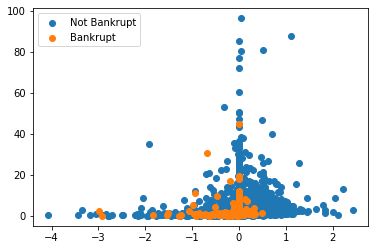

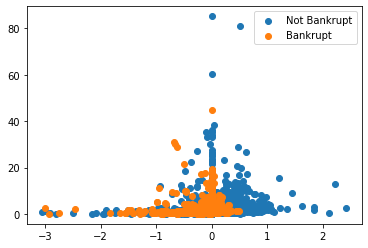

(None, None)

In [18]:
def example_plot(X,y):
    plt.scatter( y = X[y == 0]["current assets / short-term liabilities"], x= X[y == 0]["retained earnings / total assets"],label="Not Bankrupt")
    plt.scatter( y = X[y == 1]["current assets / short-term liabilities"], x =X[y == 1]["retained earnings / total assets"], label="Bankrupt")
    plt.legend()
    plt.show()
#Plot Transformed Sample
example_plot(X_train,y_train), example_plot(X_transform, y_transform)

## Comparing Techniques

In [19]:
def display_results(results,  model_names, selector_names):
    mean_accuracy = []
    std_accuracy = []
    mean_recall = []
    std_recall = []
    mean_roc_auc = []
    std_roc_auc = []


    for res in results:
        mean_accuracy.append(res["test_accuracy"].mean())
        std_accuracy.append(res["test_accuracy"].std())
        mean_recall.append(res["test_recall"].mean())
        std_recall.append(res["test_recall"].std())
        mean_roc_auc.append(res["test_roc_auc"].mean())
        std_roc_auc.append(res["test_roc_auc"].std())

    scores =  pd.DataFrame(data ={"Method": model_names, 
                        "Mean Accuracy": mean_accuracy,
                         "Stdev. Accuracy": std_accuracy,
                        "Mean Recall": mean_recall, 
                        "Stdev. Recall": std_recall,
                        "Mean ROC AUC": mean_roc_auc, 
                        "Stdev. ROC AUC": std_roc_auc,
                        } )
    if len(selector_names) != 0:
        scores["Selector"] = selector_names

    # Mean and Standard Deviation of CV. Red is minimum, Yellow is maximum 
    return scores.sort_values(["Mean Accuracy", "Mean Recall"],
                    ascending = False).style.highlight_max(color= "yellow")
                    #.highlight_min( color="coral")
    

In [20]:
"""
Compare Models with No Tuning
"""

#Oversample minority so that % of minority equals specified val
min_perc = 0.2
over = imblearn.over_sampling.SMOTE(sampling_strategy= min_perc
                                    , random_state=random_state)

#Undersample majority so that majority exceeds minority by specified val
maj_perc = 0.5
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=maj_perc
                                                   , random_state=random_state)

# Set up models
models = []

# Classifiers
logit_reg = LogisticRegression(solver='liblinear') #, multi_class='ovr'
lda =  LinearDiscriminantAnalysis()
nb = GaussianNB()
knn = KNeighborsClassifier()
dec_tree =  DecisionTreeClassifier(random_state = random_state)
rfc = RandomForestClassifier(random_state = random_state)

models.append(('LR', logit_reg))
models.append(('LDA', lda))
models.append(('NB', nb))
models.append(('KNN', knn))
models.append(('CART', dec_tree))
models.append(('RF', rfc))

model_names = []
selector_names = []
results = []

kfold = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)

for model_name, model in models:
    steps = [('scale', StandardScaler()),
                ('over', over),  
                ('under', under),
                ('model', model)]
    clf = imblearn.pipeline.Pipeline(steps = steps)
    cv_results = cross_validate(clf, X_train, y_train, cv=kfold,
                                scoring= ["accuracy","recall","roc_auc"],
                                return_estimator = False)
    model_names.append(model_name)
    results.append(cv_results)
display_results(results, model_names, [])

,Method,Mean Accuracy,Stdev. Accuracy,Mean Recall,Stdev. Recall,Mean ROC AUC,Stdev. ROC AUC
5,RF,0.914953,0.005587,0.232395,0.037480,0.775534,0.024294
1,LDA,0.881198,0.010690,0.210330,0.042667,0.721129,0.026743
0,LR,0.867748,0.008450,0.245909,0.039725,0.721443,0.024137
4,CART,0.821338,0.014982,0.314217,0.039739,0.580635,0.021689
3,KNN,0.772812,0.011169,0.409885,0.072721,0.664711,0.020351
2,NB,0.265416,0.090327,0.847094,0.077918,0.665434,0.050860


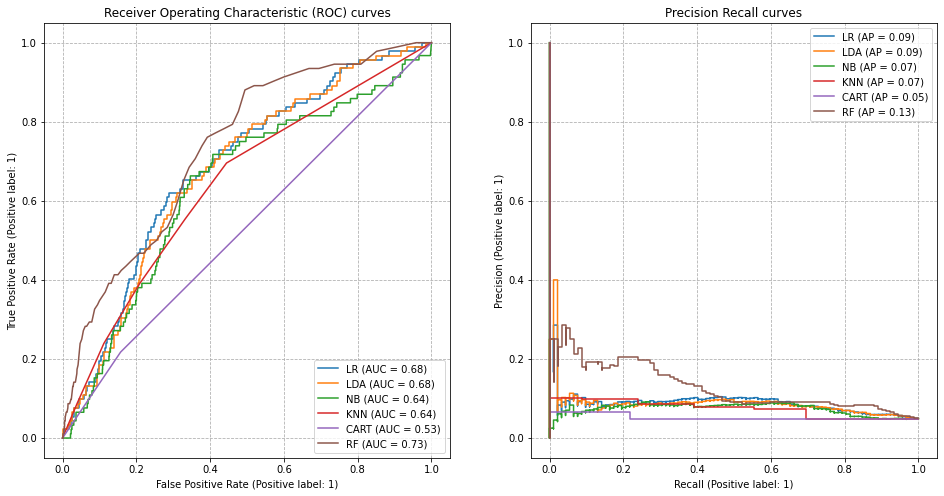

In [21]:
# Examin ROC and Precision Recall curves
# Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_det.html#sphx-glr-auto-examples-model-selection-plot-det-py
fig, [ax_roc, ax_pr] = plt.subplots(1, 2, figsize=(16, 8))

for model_name, model in models:
    steps = [('scale', StandardScaler()),
                ('over', over),  
                ('under', under),
                ('model', model)]
    clf = imblearn.pipeline.Pipeline(steps = steps)
    clf.fit(X_train, y_train)

    metrics.plot_roc_curve(clf, X_test, y_test, ax=ax_roc, name= model_name)
    metrics.plot_precision_recall_curve(clf, X_test, y_test, ax=ax_pr, name= model_name)

ax_roc.set_title('Receiver Operating Characteristic (ROC) curves')
ax_pr.set_title('Precision Recall curves')

ax_roc.grid(linestyle='--')
ax_pr.grid(linestyle='--')

plt.legend()
plt.show()

### Model Tuning

#### Fitting a Single Random Forests Classifer

In [22]:
min_perc = 0.2
over = imblearn.over_sampling.SMOTE(sampling_strategy= min_perc
                                    , random_state=random_state)

maj_perc = 0.5
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=maj_perc
                                                   , random_state=random_state)

model = RandomForestClassifier(random_state= random_state)

# sc = StandardScaler()

# X_train_tf = sc.fit_transform(X_train)
# X_test_tf = sc.transform(X_test)

steps = [('over', over),  
        ('under', under),
        ('model', model)]

clf = imblearn.pipeline.Pipeline(steps = steps)

clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_test_pred, target_names=["Not-Bankrupt","Bankrupt"]))

              precision    recall  f1-score   support

Not-Bankrupt       0.96      0.95      0.95      1804
    Bankrupt       0.17      0.22      0.19        92

    accuracy                           0.91      1896
   macro avg       0.56      0.58      0.57      1896
weighted avg       0.92      0.91      0.92      1896



Feature ranking:
1. feature (gross profit + depreciation) / total liabilities (0.069941)
2. feature gross profit (in 3 years) / total assets (0.067595)
3. feature retained earnings / total assets (0.052712)
4. feature (equity - share capital) / total assets (0.044194)
5. feature profit on operating activities / sales (0.044015)
6. feature total liabilities / ((profit on operating activities + depreciation) * (12/365)) (0.042088)
7. feature gross profit / sales (0.039311)
8. feature profit on sales / total assets (0.036090)
9. feature sales / fixed assets (0.034827)
10. feature short-term liabilities / total assets (0.032763)


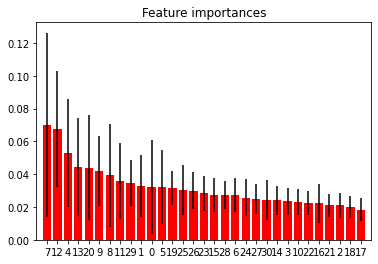

In [23]:
# Visualizing Feature Importance
forest = clf.named_steps["model"]
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [24]:
# Obatain Fiting Results for Later tuning
trial_max_depth = [estimator.tree_.max_depth for estimator in forest.estimators_]
trial_n_leaves = [estimator.tree_.n_leaves for estimator in forest.estimators_]

print("max_depth:")
print("Max: %d      Min: %d     Avg: %d" % (max(trial_max_depth), min(trial_max_depth), np.mean(trial_max_depth) ) )
print("n_leaves:")
print("Max: %d      Min: %d     Avg: %d" % (max(trial_n_leaves), min(trial_n_leaves), np.mean(trial_n_leaves) ) )

max_depth:
Max: 25      Min: 17     Avg: 20
n_leaves:
Max: 468      Min: 392     Avg: 433


### Grid Search Cross Validation

In [25]:
#min_perc = 0.2
over = imblearn.over_sampling.SMOTE()
    #sampling_strategy= min_perc

#maj_perc = 0.5
under = imblearn.under_sampling.RandomUnderSampler()
    #sampling_strategy=maj_perc)

model = RandomForestClassifier(random_state=random_state,
                               n_jobs = 2)

steps = [('over', over),  
        ('under', under),
        ('model', model)]

clf = imblearn.pipeline.Pipeline(steps = steps)

param_grid = {
    'over__sampling_strategy': [0.1, 0.2, 0.3],
    'under__sampling_strategy': [0.5, 0.6, 0.9],
    'model__max_depth': [5, 15, 30],
    'model__min_samples_split': [2, 20, 50]
    }

kfold = RepeatedStratifiedKFold( n_splits=10, n_repeats=10, 
                                random_state=random_state)

search = GridSearchCV(
    estimator=clf, param_grid=param_grid,
    scoring="recall", cv= kfold,
    n_jobs=4
)

search.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=0),
             estimator=Pipeline(steps=[('over', SMOTE()),
                                       ('under', RandomUnderSampler()),
                                       ('model',
                                        RandomForestClassifier(n_jobs=2,
                                                               random_state=0))]),
             n_jobs=4,
             param_grid={'model__max_depth': [5, 15, 30],
                         'model__min_samples_split': [2, 20, 50],
                         'over__sampling_strategy': [0.1, 0.2, 0.3],
                         'under__sampling_strategy': [0.5, 0.6, 0.9]},
             scoring='recall')

In [26]:
# Show top Results based on Recall
results_df = pd.DataFrame(search.cv_results_)
results_df = results_df.sort_values(by=['rank_test_score'])
results_df = (
    results_df
    .set_index(results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
results_df[
    ['rank_test_score', 'mean_test_score', 'std_test_score']
].head(20)

,rank_test_score,mean_test_score,std_test_score
kernel,,,
5_50_0.1_0.9,1,0.696276,0.079986
5_2_0.1_0.9,2,0.692275,0.075473
5_20_0.1_0.9,3,0.690908,0.086841
5_50_0.2_0.9,4,0.674947,0.078038
30_50_0.1_0.9,5,0.673979,0.081687
5_20_0.2_0.9,6,0.668814,0.076377
5_2_0.2_0.9,7,0.667132,0.085394
15_50_0.1_0.9,8,0.666299,0.083943
5_50_0.3_0.9,9,0.662980,0.079465


### Final Model

In [27]:
min_perc = 0.1
over = imblearn.over_sampling.SMOTE(sampling_strategy= min_perc
                                    , random_state=random_state)

maj_perc = 0.9
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=maj_perc
                                                   , random_state=random_state)

model = RandomForestClassifier(max_depth =  5,
                            min_samples_split = 50,
                            min_impurity_decrease = 0,
                            max_features = 10,
                            random_state= random_state)

steps = [('over', over),  
        ('under', under),
        ('model', model)]

clf = imblearn.pipeline.Pipeline(steps = steps)

clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_test_pred, target_names=["Not-Bankrupt","Bankrupt"]))

              precision    recall  f1-score   support

Not-Bankrupt       0.97      0.73      0.83      1804
    Bankrupt       0.10      0.60      0.17        92

    accuracy                           0.72      1896
   macro avg       0.54      0.66      0.50      1896
weighted avg       0.93      0.72      0.80      1896



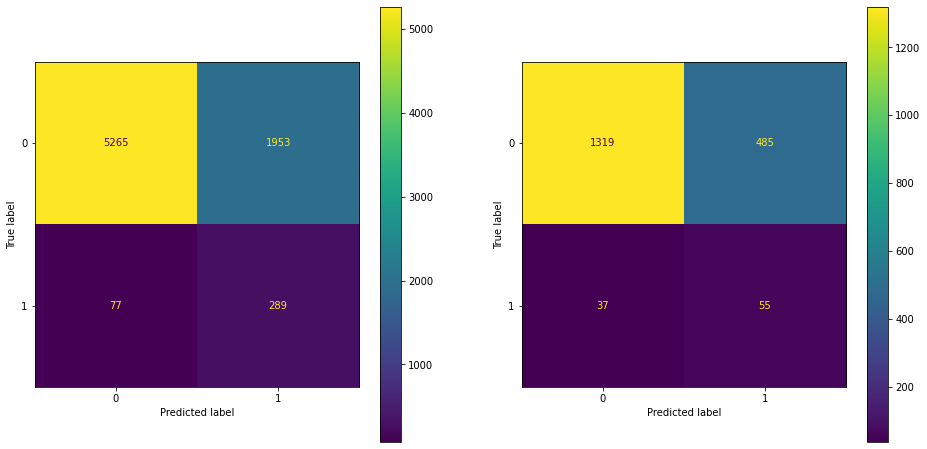

In [28]:
fig, [ax_train, ax_test] = plt.subplots(1, 2, figsize=(16, 8))
metrics.plot_confusion_matrix(clf, X_train, y_train, ax=ax_train)
metrics.plot_confusion_matrix(clf, X_test, y_test, ax=ax_test)

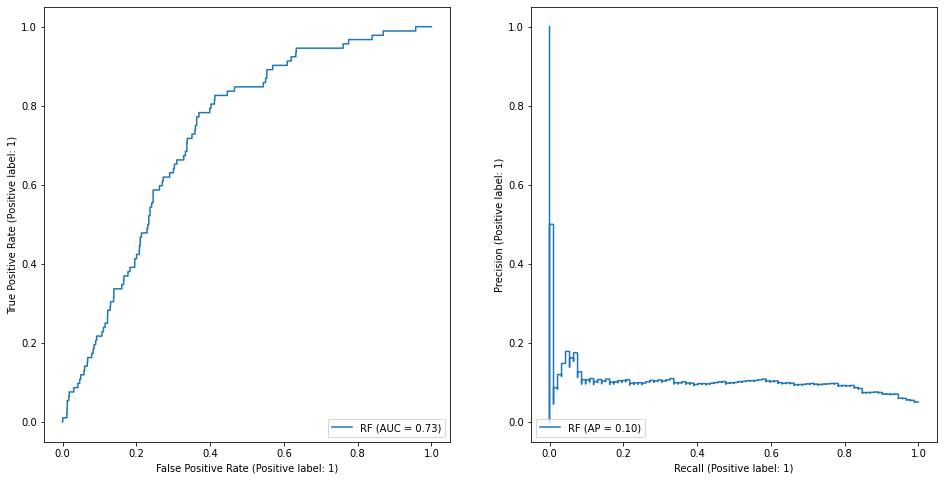

In [29]:
fig, [ax_roc, ax_pr] = plt.subplots(1, 2, figsize=(16, 8))
metrics.plot_roc_curve(clf, X_test, y_test, ax=ax_roc, name= model_name)
metrics.plot_precision_recall_curve(clf, X_test, y_test, ax=ax_pr, name= model_name)

Feature ranking:
1. feature (gross profit + depreciation) / total liabilities (0.203099)
2. feature gross profit (in 3 years) / total assets (0.132665)
3. feature gross profit / sales (0.064013)
4. feature equity / total assets (0.061123)
5. feature short-term liabilities / total assets (0.058211)
6. feature (equity - share capital) / total assets (0.050528)
7. feature sales / fixed assets (0.046746)
8. feature retained earnings / total assets (0.045890)
9. feature EBIT / total assets (0.044134)
10. feature profit on operating activities / sales (0.033739)


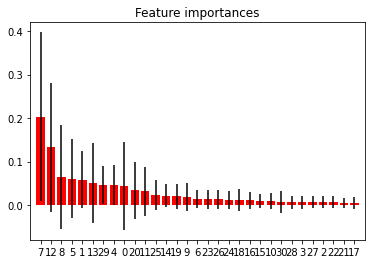

In [30]:
# Visualizing Feature Importance
forest = clf.named_steps["model"]
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()